# (PART2) 튼튼한 GAN 만들기

## (CHAPTER5) GAN 개념  

### 이미지 생성하기  
백쿼리(backquery)를 통해 생성된 이미지의 특징  
- 같은 원핫 인코딩 백터에서의 같은 결과  
- 해당 레이블의 트레이닝 이미지들의 평균적인 이미지가 생성됨  
  
네트워크 모델을 이용하여 얻어내고 싶은 이상적인 결과  
- 서로 다른 이미지들을 만들어 내기  
- 트레이닝 이미질과 같은 퀄리티의 이미지  

But, 간단한 백쿼리로는 이와 같은 목적 달성 어려움  

### 적대적 훈련  
뉴럴넷 두개를 사용.  
이들을 각각 생성기와 판별기  
"어떻게 훈련을 하느냐?" # 이 부분이 GAN의 핵심  
  
<트레이닝 포인트(by loss function)>  
* 판별기를 무사히 속이면 생성기에 보상을 준다  
* 판별기가 정상적으로 판별하면 생성기에 벌을 준다  
  
  
<b>GAN 트레이닝의 장점</b>  
진짜 이미지를 판단하기 위해서 어떤 방식을 따르고  
어떤 손실함수를 거쳐야 하는지를 설정하지 않아도 됨  
생성에 관련된 handcraft loss function이 아님  
단순한 기존 loss의 조합으로 구현 가능함  

### GAN 훈련  
제대로 훈련하기 위해서는 두개의 NN을 동시에 훈련시키면서  
밸런스도 유지되도록(비슷한 수준으로 훈련되도록) 유도해야 함  
  
단계를 총 3개로 나누어 설명  
<b><span style="color:red">1단계:</span></b> 판별기에 실제 데이터를 입력, 라벨 1으로 학습  
<b><span style="color:red">2단계:</span></b> 판별기에 생성기로부터 만들어진 페이크 데이터를 입력, 라벨 0으로 학습  
<b><span style="color:red">3단계:</span></b> 판별기에 생성기의 결과를 입력, 생성기에 결과가 1이 되도록 학습  


### 훈련하기 어려운 GAN  
실무에서는 GAN을 훈련하는 것이 굉장히 까다로움  
서로 균형이 맞춰져 있어야만 GAN이 제대로 훈련됨  

### 핵심 정리  
* 분류는 데이터를 감소시키는 것에서 출발함.  
입력값을 줄여 클래스당 하나의 출력값을 가지도록 만드는 행위임.  
* 생성은 데이터를 확장하여 얻어내는 것.  
생성적 신경망은 작은 수의 시드(seed)를 훨씬 큰 크기의 출력값으로 확장하는 역할을 수행.  
* 생성적 적대 신경망은 두개의 신경망 모델을 포함함.  
생성기와 판별기, 이들은 서로 적대시하도록 만들어져 있음.  
* GAN을 설계하고 훈련하는 일은 어려움.  
어떤 경우에 실패하고 성공하는지 성숙하지 않음 # 지금은 모르겠음  
* 일반적인 GAN은 3단계로 파라미터 업데이트 진행.  
    1. D를 실제 데이터로 트레이닝
    2. D를 G로 생성된 데이터로 트레이닝  
    3. G가 D의 결과가 실제로 나오도록 트레이닝  

## (CHAPTER6) 단순한 1010 패턴

In [9]:
import torch
import torch.nn as nn

import random
import pandas
import matplotlib.pyplot as plt

### 실제 데이터 소스

In [10]:
def generate_real():
    # real_data = torch.FloatTensor([1, 0, 1, 0])
    real_data = torch.FloatTensor(
        [
            random.uniform(0.8, 1.0),
            random.uniform(0, 0.2),
            random.uniform(0.8, 1.0),
            random.uniform(0.0, 0.2),
        ]
    )
    return real_data


generate_real()

tensor([0.9969, 0.1909, 0.9095, 0.0168])

### 판별기 만들기

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(4,3), nn.Sigmoid(), nn.Linear(3,1), nn.Sigmoid())
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0 # count epoch
        self.progress = [] # for appending loss
    

    def train(self, inputs, targets):
        """params update와 logging까지 같이 수행하는 함수

        Args:
            inputs (torch.Tensor): 데이터
            targets (torch.Tensor): 라벨
        """
        outputs = self.forward(inputs) # forward
        loss:torch.Tensor = self.loss_function(outputs, targets) # loss
        
        # appending loss
        self.counter += 1
        if  (self.counter % 10 == 0):
            self.progress.append(loss.item())
        # print info
        if (self.counter % 10000 == 0):
            print(f"counter = {self.counter}")
            

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
    
    def forward(self, x):
        return self.model(x)

### 판별기 테스트하기

In [20]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

generate_random(4)

tensor([0.9564, 0.9612, 0.3338, 0.2776])

counter = 10000
counter = 20000


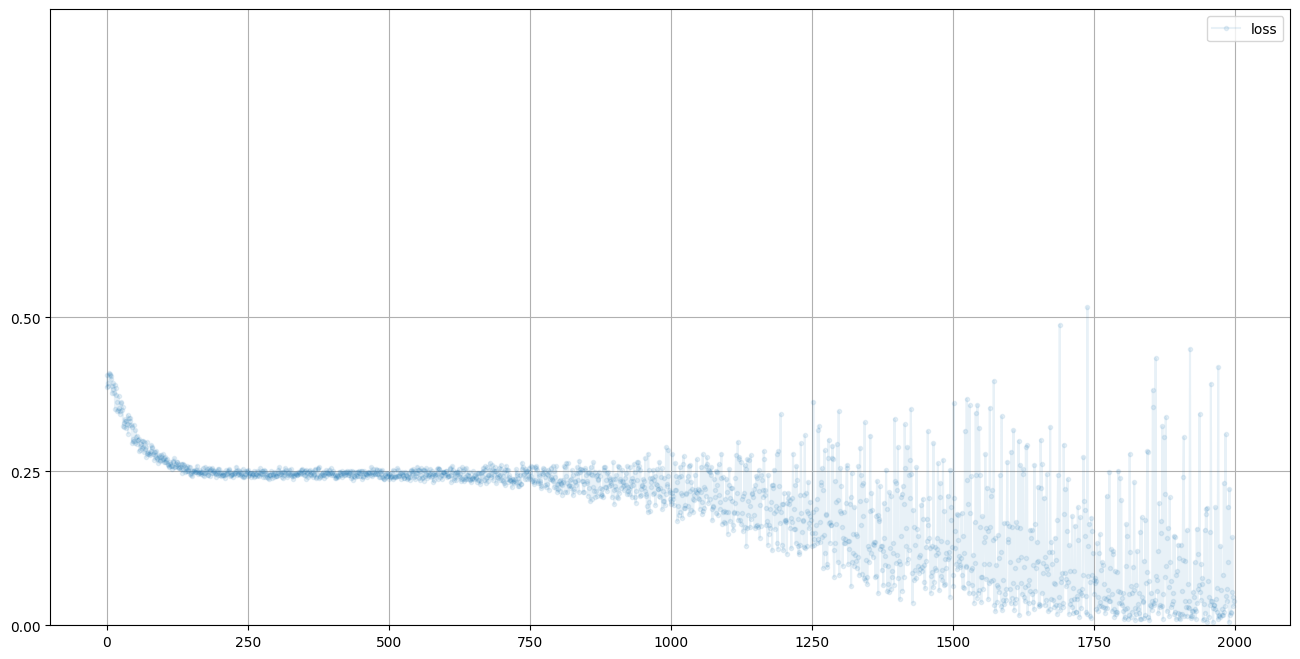

In [22]:
D = Discriminator()

for i in range(10000):
    # 1에폭에 2번 update
    D.train(generate_real(), torch.FloatTensor([1.0])) 
    D.train(generate_random(4), torch.FloatTensor([0.0]))

D.plot_progress()

In [26]:
# predictions
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7404302954673767
0.07978558540344238


### 생성기 만들기

### 생성기 결과 확인하기

### GAN 훈련하기

### 핵심정리

## (CHAPTER7) 손으로 쓴 숫자 훈련

### 데이터셋 클래스

### MNIST 판별기

### 판별기 테스트하기

### MNIST 생성기

### 생성기 결과 확인하기

### GAN 훈련하기

### 모드 붕괴

### GAN 훈련 성능 확인하기

### 시드로 실험하기

### 핵심 정리

## (CHAPTER8) 얼굴 이미지

### 컬러 이미지

### CelebA 데이터셋

### 계층적 데이터 형식

### 데이터 가져오기

### 데이터 살펴보기

### 데이터셋 클래스

### 판별기

### 판별기 테스트하기

### GPU 가속

### 생성기

### 생성기 결과 확인하기

### GAN 훈련하기

### 핵심 정리